[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/07_distance_zonal_stats.ipynb)

In [ ]:
#| default_exp distance_zonal_stats

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson files from repo

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| include: false
import warnings

from shapely.errors import ShapelyDeprecationWarning

In [ ]:
#| include: false
warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

In [ ]:
#| export
from typing import Any, Dict, List

import geopandas as gpd

import geowrangler.area_zonal_stats as azs
import geowrangler.vector_zonal_stats as vzs
from geowrangler.vector_zonal_stats import GEO_INDEX_NAME

In [ ]:
#| include: false
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [ ]:
#| exporti
INTERNAL_DISTANCE_COL = "__Geowrangleer_nearest_distance"


def build_agg_distance_dicts(expanded_aggs, distance_col):
    agg_dicts = vzs._build_agg_args(expanded_aggs)
    if distance_col is not None:
        agg_dicts[distance_col] = (INTERNAL_DISTANCE_COL, "mean")
    return agg_dicts

In [ ]:
#| export
def create_distance_zonal_stats(
    aoi: gpd.GeoDataFrame,  # Area of interest for which zonal stats are to be computed for
    data: gpd.GeoDataFrame,  # Source gdf of region/areas containing data to compute zonal stats from
    max_distance: float,  # max distance to compute distance for (the larger the slower the join), set to None for no limit
    aggregations: List[Dict[str, Any]] = [],  # aggregations
    distance_col: str = "nearest",  # column name of the distance column, set to None if not wanted in results
):
    """Computes zonal stats based on nearest matching data geometry within `max_distance`.
    Note that setting a too high max_distance (or None) will incur a performance cost.
    """
    # aoi/data crs should be planar
    azs.validate_area_aoi(aoi)
    azs.validate_area_data(data)

    fixed_aggs = [vzs._fix_agg(agg) for agg in aggregations]

    vzs._validate_aggs(fixed_aggs, data)

    # reindex aoi
    aoi_index_name = aoi.index.name
    aoi = vzs._prep_aoi(aoi)

    # sync aoi/data crs
    if not data.crs.equals(aoi.crs):
        data = data.to_crs(aoi.crs)

    # add spatial indexes
    aoi.geometry.sindex
    data.geometry.sindex

    # nearest
    nearest = gpd.sjoin_nearest(
        aoi[[GEO_INDEX_NAME, "geometry"]],
        data,
        how="inner",
        max_distance=max_distance,
        distance_col=INTERNAL_DISTANCE_COL,
    )

    groups = nearest.groupby(GEO_INDEX_NAME)

    expanded_aggs = vzs._expand_aggs(fixed_aggs)
    agg_distance_dicts = build_agg_distance_dicts(expanded_aggs, distance_col)

    aggregates = groups.agg(**agg_distance_dicts)

    results = aoi.merge(
        aggregates, how="left", on=GEO_INDEX_NAME, suffixes=(None, "_y")
    )
    results = vzs._fillnas(expanded_aggs, results, aoi)

    results = results.set_index(GEO_INDEX_NAME)
    results.index.name = aoi_index_name
    return results

## Test data

### Simple squares

In [ ]:
#| include: false
def make_point_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            Point(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [ ]:
#| include: false
def square(x, y, size=1):
    return Polygon([(x, y), (x, size + y), (size + x, size + y), (size + x, y)])

In [ ]:
#| include: false
def make_df(
    xsize,
    ysize,
    has_internet=True,
    has_population=True,
    size=1,
    offset_x=0.25,
    offset_y=0.0,
    pop_x_factor=100,
    pop_y_factor=0,
    internet_base_speed=20.0,
    internet_x_exp=2.0,
    internet_y_factor=100,
    crs="EPSG:3857",
):
    d = dict(
        geometry=[
            square(x + offset_x, y + offset_y)
            for x in range(xsize)
            for y in range(ysize)
        ]
    )
    if has_population:
        d["population"] = [
            pop_x_factor * (x + 1) + y * (pop_x_factor * ysize + pop_y_factor)
            for x in range(xsize)
            for y in range(ysize)
        ]
    if has_internet:
        d["internet_speed"] = [
            internet_base_speed / (internet_x_exp**x) + internet_y_factor * y
            for x in range(xsize)
            for y in range(ysize)
        ]
    return gpd.GeoDataFrame(d, crs=crs)

In [ ]:
#| include: false
simple_aoi = make_df(3, 1, has_internet=False, has_population=False, offset_x=0.0)
simple_data = make_df(3, 1)

In [ ]:
#| include: false
simple_point_data = make_point_df(3, 5, offset_x=0.5, offset_y=3.0)

Given an aoi (`simple_aoi`) and geodataframe containing sample data (`simple_data`)

In [ ]:
simple_aoi

,geometry
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))"
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))"
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))"


In [ ]:
simple_data

,geometry,population,internet_speed
0,"POLYGON ((0.25 0, 0.25 1, 1.25 1, 1.25 0, 0.25...",100,20.0
1,"POLYGON ((1.25 0, 1.25 1, 2.25 1, 2.25 0, 1.25...",200,10.0
2,"POLYGON ((2.25 0, 2.25 1, 3.25 1, 3.25 0, 2.25...",300,5.0


We also have simple point data which do not intersect with our AOIs.

In [ ]:
simple_point_data

,geometry,population,internet_speed
0,POINT (0.5 3),100,20.0
1,POINT (0.5 4),600,120.0
2,POINT (0.5 5),1100,220.0
3,POINT (0.5 6),1600,320.0
4,POINT (0.5 7),2100,420.0
5,POINT (1.5 3),200,10.0
6,POINT (1.5 4),700,110.0
7,POINT (1.5 5),1200,210.0
8,POINT (1.5 6),1700,310.0
9,POINT (1.5 7),2200,410.0


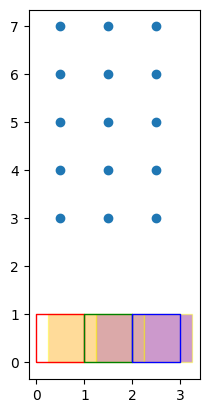

In [ ]:
ax = plt.axes()
ax = simple_data.plot(
    ax=ax, color=["orange", "brown", "purple"], edgecolor="yellow", alpha=0.4
)
ax = simple_aoi.plot(ax=ax, facecolor="none", edgecolor=["r", "g", "b"])
ax = simple_point_data.plot(ax=ax)

The red,green,blue outlines are the 3 regions of interest (aoi) while the orange,brown, purple areas are the data areas.The blue dots are data which do not intersect our AOIs. 

In [ ]:
%%time
results = create_distance_zonal_stats(
    simple_aoi,
    simple_point_data,
    max_distance=7,
    aggregations=[
        dict(func="count"),
        dict(func="sum", column="population"),
        dict(func="mean", column="internet_speed"),
    ],
)

CPU times: user 6.39 ms, sys: 764 µs, total: 7.16 ms
Wall time: 6.84 ms


In [ ]:
results

,geometry,index_count,population_sum,internet_speed_mean,nearest
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",1,100,20.0,2.0
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",1,200,10.0,2.0
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",1,300,5.0,2.0


In [ ]:
%%time
results2 = create_distance_zonal_stats(
    simple_aoi,
    simple_data,
    max_distance=1,
    aggregations=[
        dict(func="count"),
        dict(func="sum", column="population"),
        dict(func="mean", column="internet_speed"),
    ],
)

CPU times: user 6.3 ms, sys: 560 µs, total: 6.86 ms
Wall time: 6.65 ms


In [ ]:
results2

,geometry,index_count,population_sum,internet_speed_mean,nearest
0,"POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))",1,100,20.0,0.0
1,"POLYGON ((1 0, 1 1, 2 1, 2 0, 1 0))",2,300,15.0,0.0
2,"POLYGON ((2 0, 2 1, 3 1, 3 0, 2 0))",2,500,7.5,0.0
